In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


# **Dataset Preperation**

In [ ]:
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import os
import torchvision
from tqdm import tqdm
from torchvision import datasets, models, transforms 
from PIL import Image

#vgg16 = torchvision.models.vgg16(pretrained=True)

class HARDataset(Dataset):
    """
    Custom dataset for HAR images that returns transformed image array and corresponding class
    """
    
    def __init__(self, data, img_dir, transform=None):
        """
        Inputs:
            data (list): 2D list in the form of [[class, file_name]]
            img_dir (String): directory of the folder with all the images
            transform (torchvision.transforms): transformation to be applied to images
        """
        self.data = np.array(data)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = os.path.join(self.img_dir, self.data[idx, 1])
        img_class = int(self.data[idx, 0])
        image = plt.imread(image_name)
        if self.transform:
            image = self.transform(np.array(image))
        
        img_one_hot = torch.zeros(15)
        img_one_hot[img_class] = 1
        sample = {'image': image, 'img_class': img_one_hot}
        return sample

def filename_loader():
    """
    Helper function that loads image file name and corresponding class from 'Human Action Recognition' folder
    """
    train = pd.read_csv('/content/drive/My Drive/Human Action Recognition/Training_set.csv')

    # one-hot encoding not needed for nn.CrossEntropyLoss()(x,y)
    # y is the index for the class (0 to 14) and x is the output from the model without sigmoid (1x15 tensor)
    classes = {
        "sitting":0,
        "using_laptop":1,
        "hugging":2,
        "sleeping":3,
        "drinking":4,
        "clapping":5,
        "dancing":6,
        "cycling":7,
        "calling":8,
        "laughing":9,
        "eating":10,
        "fighting":11,
        "listening_to_music":12,
        "running":13,
        "texting":14,
    }
    images = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[],
        5:[],
        6:[],
        7:[],
        8:[],
        9:[],
        10:[],
        11:[],
        12:[],
        13:[],
        14:[]
    }
    train_images = []
    val_images = []

    for _, data in train.iterrows():
        img_class = classes[data[1]]
        images[img_class].append([img_class, data[0]])
    
    for img_class, imgs in images.items():
        train_split = int(len(imgs) * 0.8) # 80/20 training/validation split for each class
        train_images += imgs[:train_split]
        val_images += imgs[train_split:]

    return train_images, val_images

def data_loader(batch_size=64, shuffle=True, num_workers=0):
    """
    Returns DataLoader objects for train and validation data
    """
    train_images, val_images = filename_loader()

    # normalize the pixel values to between 0 and 1 and crop to same size for DataLoader to work
    img_dir = '/content/drive/My Drive/Human Action Recognition/train'
    
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Resize((224,224)),
                                    transforms.CenterCrop(224),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    # Resize and crop images into size 224 x 224

    val_dataset = HARDataset(data=val_images, img_dir=img_dir, transform=transform)
    train_dataset = HARDataset(data=train_images, img_dir=img_dir, transform=transform)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return train_loader, val_loader

# **Training**

In [ ]:
#from preprocessing import data_loader
#from model import CNN
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def train(net, train_loader, val_loader, batch_size=32, lr=0.001, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(0)

    if torch.cuda.is_available():
        net = net.cuda()

    # cross entropy loss function and adaptive moment estimation optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(net.parameters(), lr = lr, weight_decay=0.1)

    # softmax for predictions
    softmax = nn.Softmax(dim = 1)
    
    # initialize error and loss history
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0.0
        total_train_err = 0.0
        train_iters = 0

        total_val_loss = 0.0
        total_val_err = 0.0
        val_iters = 0
        
        train_batches = 0
        net.train()
        for batch in train_loader:
            train_batches += 1
            imgs, labels = batch.values()
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            optimizer.zero_grad()
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            pred = softmax(outputs)
            # find error and loss for training data
            total_train_err += (np.argmax(pred.detach().cpu(), 1) != np.argmax(labels.cpu(), 1)).sum().item()
            total_train_loss += loss.item()
            train_iters += len(labels)

        val_batches = 0
        net.eval()
        for batch in val_loader:
            val_batches += 1
            imgs, labels = batch.values()
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            outputs = net(imgs)
            loss = criterion(outputs, labels)

            pred = softmax(outputs)

            # find error and loss for training data
            total_val_err += (np.argmax(pred.detach().cpu(), 1) != np.argmax(labels.cpu(), 1)).sum().item()
            total_val_loss += loss.item()
            val_iters += len(labels)

        # record the average error (per iteration) and loss (per batch) for each epoch
        train_err[epoch] = total_train_err / train_iters
        train_loss[epoch] = total_train_loss / train_batches
        val_err[epoch] = total_val_err / val_iters
        val_loss[epoch] = total_val_loss / val_batches
        print(f"Epoch {epoch}: Train err: {train_err[epoch]} Val err: {val_err[epoch]} Train loss: {train_loss[epoch]} Val loss: {val_loss[epoch]}")
        # save model
        model_path = "/content/drive/My Drive/Human Action Recognition/vgg_model/bs{}_lr{}_epoch{}".format(batch_size,
                                              lr,
                                              epoch)
        torch.save(net.state_dict(), model_path)
    return train_err, train_loss, val_err, val_loss

# **Evaluate performance (validation)**

In [ ]:
def performance_per_class(net):
    net.eval()
    _, val_loader = data_loader(batch_size=1)
    errors = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:0,
        6:0,
        7:0,
        8:0,
        9:0,
        10:0,
        11:0,
        12:0,
        13:0,
        14:0,
    }
    total = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:0,
        6:0,
        7:0,
        8:0,
        9:0,
        10:0,
        11:0,
        12:0,
        13:0,
        14:0,
    }
    wrong_guesses = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:0,
        6:0,
        7:0,
        8:0,
        9:0,
        10:0,
        11:0,
        12:0,
        13:0,
        14:0,
    }
    guesses = {
        0:0,
        1:0,
        2:0,
        3:0,
        4:0,
        5:0,
        6:0,
        7:0,
        8:0,
        9:0,
        10:0,
        11:0,
        12:0,
        13:0,
        14:0,
    }
    softmax = nn.Softmax(dim = 1)
    for batch in val_loader:
        img, label = batch.values()
        output = softmax(net(img))
        pred = np.argmax(output.detach()).item()
        truth = np.argmax(label).item()
        if pred != truth:
            errors[truth] += 1
            wrong_guesses[pred] += 1
        total[truth] += 1
        guesses[pred] += 1
    for i in range(15):
        wrong_guesses[i] /= guesses[i]
        errors[i] /= total[i]
    return errors, wrong_guesses, guesses

# **Evaluate performance (test)**

In [ ]:
def test_filename_loader():
    """
    Helper function that loads image file name and corresponding class from 'Human Action Recognition' folder
    """
    test = pd.read_csv('/content/drive/My Drive/Human Action Recognition/Testing_set.csv')

    # one-hot encoding not needed for nn.CrossEntropyLoss()(x,y)
    # y is the index for the class (0 to 14) and x is the output from the model without sigmoid (1x15 tensor)
    classes = {
        "sitting":0,
        "using_laptop":1,
        "hugging":2,
        "sleeping":3,
        "drinking":4,
        "clapping":5,
        "dancing":6,
        "cycling":7,
        "calling":8,
        "laughing":9,
        "eating":10,
        "fighting":11,
        "listening_to_music":12,
        "running":13,
        "texting":14,
    }
    images = {
        0:[],
        1:[],
        2:[],
        3:[],
        4:[],
        5:[],
        6:[],
        7:[],
        8:[],
        9:[],
        10:[],
        11:[],
        12:[],
        13:[],
        14:[]
    }
    test_images = []

    for _, data in test.iterrows():
        if (data[1] in classes.keys()):
            img_class = classes[data[1]]
            images[img_class].append([img_class, data[0]])
    
    for imgs in images.values():
        test_images += imgs

    return test_images

def test_data_loader(batch_size=64, shuffle=True, num_workers=0):
    """
    Returns DataLoader objects for train and validation data
    """
    test_images = test_filename_loader()

    # normalize the pixel values to between 0 and 1 and crop to same size for DataLoader to work
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), transforms.FiveCrop(150), transforms.Lambda(lambda crops: torch.stack([crop for crop in crops])), transforms.Resize((224, 224))])
    img_dir = '/content/drive/My Drive/Human Action Recognition/test'

    test_dataset = HARDataset(data=test_images, img_dir=img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return test_loader


def get_test_acc(net):
    if torch.cuda.is_available():
        net.cuda()

    test_loader = test_data_loader()
    softmax = nn.Softmax(dim=1)
    total_test_acc = 0.0
    num_images = 0
    for batch in test_loader:
        for image, img_class in zip(batch["image"], batch["img_class"]):
            num_images += 1
            avg_output = torch.zeros((1,15))
            if torch.cuda.is_available():
                image.cuda()
                img_class.cuda()
                avg_output.cuda()
            for x in range(5):
                avg_output += net(image[x].unsqueeze(0))
            avg_output /= 5
            pred = softmax(avg_output)
            total_test_acc += (np.argmax(pred.detach().cpu(), 1) == np.argmax(img_class.unsqueeze(0).cpu(), 1)).sum().item()
    return total_test_acc / num_images

In [ ]:
train_loader, val_loader = data_loader(batch_size=128)

# **VGG 16**

In [ ]:
def get_pretrained_model(model_name):

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 15))

    return model

In [ ]:
from torchsummary import summary
model = get_pretrained_model('vgg16')
summary(model, input_size=(3, 224, 224), batch_size=128, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
             ReLU-14         [128, 256,

In [ ]:

train(model, train_loader, val_loader, batch_size=128, lr=0.001, num_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0: Train err: 0.47430555555555554 Val err: 0.3686507936507937 Train loss: 1.468789222874219 Val loss: 1.148471787571907


 20%|██        | 1/5 [2:44:57<10:59:48, 9897.19s/it]

Epoch 1: Train err: 0.3876984126984127 Val err: 0.34246031746031746 Train loss: 1.1820259803458104 Val loss: 1.0846404165029526


 40%|████      | 2/5 [4:41:37<6:49:38, 8192.87s/it] 

In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/Human Action Recognition/vgg_best/bs128_lr0.001_epoch5", map_location=torch.device('cpu')))
error_rate, wrong_guess_rate, guesses = performance_per_class(model)
print("error rate", error_rate)

error rate {0: 0.40476190476190477, 1: 0.27976190476190477, 2: 0.38095238095238093, 3: 0.25595238095238093, 4: 0.2976190476190476, 5: 0.35714285714285715, 6: 0.20833333333333334, 7: 0.041666666666666664, 8: 0.8273809523809523, 9: 0.35714285714285715, 10: 0.06547619047619048, 11: 0.24404761904761904, 12: 0.5654761904761905, 13: 0.22023809523809523, 14: 0.6309523809523809}


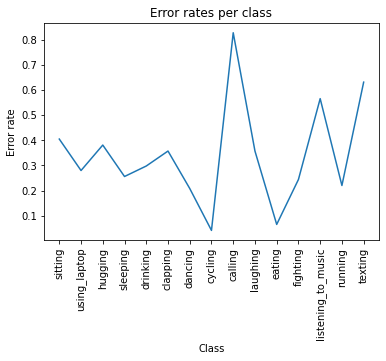

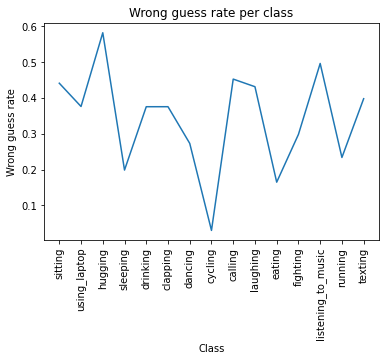

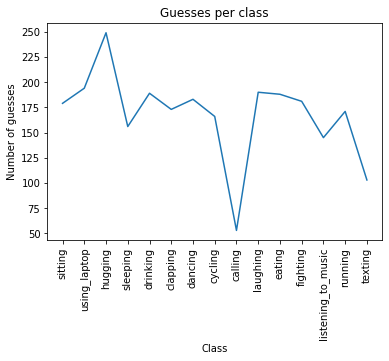

In [ ]:
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
xtick = ["sitting", "using_laptop", "hugging", "sleeping", "drinking", "clapping", "dancing", "cycling",
  "calling", "laughing", "eating", "fighting", "listening_to_music", "running", "texting"]

plt.xticks(x, xtick, rotation = 90)
plt.plot(x, list(error_rate.values()))
plt.title("Error rates per class")
plt.xlabel("Class")
plt.ylabel("Error rate")
plt.show()
plt.xticks(x, xtick,rotation = 90)
plt.plot(x, list(wrong_guess_rate.values()))
plt.title("Wrong guess rate per class")
plt.xlabel("Class")
plt.ylabel("Wrong guess rate")
plt.show()
plt.xticks(x, xtick, rotation=90)
plt.plot(x, list(guesses.values()))
plt.title("Guesses per class")
plt.xlabel("Class")
plt.ylabel("Number of guesses")
plt.show()

In [ ]:
model.load_state_dict(torch.load("/content/drive/My Drive/Human Action Recognition/vgg_best/bs128_lr0.001_epoch1", map_location=torch.device('cpu')))
test_accuracy = get_test_acc(model)
print(f'Test accuracy: {test_accuracy}')

Test accuracy: 0.33653846153846156
